# Setting up your environment
***
Run the cells below to install all packages and import the necessary code

In [1]:
%pip install --upgrade pip
# OpenAI Gym related:
%pip install cmake
%pip install atari_py 
'''OpenAI devs actually messed up an indentation
    in the video recorder class in 0.18.x.
    If you want to see videos, wait for a patch or
    use 0.17.x.
'''
%pip install gym[box2d]==0.17.3
%pip install pyvirtualdisplay
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip uninstall -y gym_lunarlanderhardcore
%pip install gym_lunarlanderhardcore/

Found existing installation: gym-lunarlanderhardcore 0.1Note: you may need to restart the kernel to use updated packages.
Uninstalling gym-lunarlanderhardcore-0.1:
  Successfully uninstalled gym-lunarlanderhardcore-0.1

Processing c:\users\nikla\workspace\jupyter-notebooks\gym_lunarlanderhardcore
Note: you may need to restart the kernel to use updated packages.


  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


  Created wheel for gym-lunarlanderhardcore: filename=gym_lunarlanderhardcore-0.1-py3-none-any.whl size=3659 sha256=7860b7f8f01dcd0afe4e98d101e28049cb75fc97c396aab628a18e57cfd4e371
  Stored in directory: C:\Users\nikla\AppData\Local\Temp\pip-ephem-wheel-cache-1hcbuk9i\wheels\8b\ab\a9\13277215fad19f588175fc439c206ba62e502a435b0d9ef058
Successfully built gym-lunarlanderhardcore


In [3]:
'''
    Utility code to display the runs as video
'''
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !apt-get install -y xvfb python-opengl > /dev/null 2>&1

from IPython import display
import numpy as np
import base64
import io
import gym
from tqdm import tqdm
from gym.wrappers import Monitor

if IN_COLAB:
    from pyvirtualdisplay import Display
    d = Display()
    d.start()

'''
Below is a solution to record and display videos for
OpenAI Gym environments.
Why the hassle?
    It works both in Jupyter Notebook and Google Colab!
(The author would like to note how painful it has been
developing this)
'''    

def display_video_from_monitor(monitor):
    '''
    Converts all videos in a monitor to HTML videos
    '''
    if len(monitor.videos) == 0:
        print("No videos to render!")
        return
    for f in monitor.videos:
        video = io.open(f[0], 'r+b').read()
        encoded = base64.b64encode(video)

        display.display(display.HTML(data="""
            <video alt="test" controls>
            <source src="data:video/mp4;base64,{0}" type="video/mp4" />
            </video>
            """.format(encoded.decode('ascii'))))
    return

def make_video(env, model, max_steps=None):
    mon = Monitor(env, "/data/videos/", force=True)
    state = mon.reset()
    i = 0
    while True:
        action = model(state)
        state, r, d, _ = mon.step(action)
        if d: break
        i+=1
        if max_steps is not None and i>=max_steps: break
    if mon.stats_recorder.done == False:    
        mon.stats_recorder.save_complete()
        mon.stats_recorder.done = True
    mon.reset()
    display_video_from_monitor(mon)
    return mon

In [4]:
'''
    ActorCritic class, useful for solving the task
'''
import numpy as np
from tensorflow.keras.layers import (
    Dense, Input, Dropout    
)
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.losses import Huber
from tensorflow import keras
from tqdm import tqdm
import matplotlib.pyplot as plt

import gym

import pandas as pd

def mov_avg(x, l):
    return pd.Series(x).rolling(l).mean().iloc[l-1:].values

def episode(env, model, max_steps=None):
    '''
    Runs a single episode of the model in env for at most max_steps
    Returns states, rewards, action_probabilities and the
    estimated rewards by the critic.
    '''
    states = []
    action_probs = []
    est_rewards = []
    rewards = []

    state = env.reset()
    i = 0
    max_steps = np.inf if max_steps is None else max_steps
    while i < max_steps:
        state = tf.convert_to_tensor(state)
        state = tf.expand_dims(state, 0)
        states.append(state)
        a_p, e_w = model(state)

        action = np.random.choice(env.action_space.n, p=np.squeeze(a_p))
        state, reward, done, info = env.step(action)

        action_probs.append(a_p[0, action])
        est_rewards.append(e_w[0,0])
        rewards.append(reward)

        i += 1
        if done:
            break
    env.close()
    return states, rewards, action_probs, est_rewards

def sample_action(model, state):
    '''
    Given a model and a state, samples an action from model
    '''
    with tf.device("/cpu:0"):
        state = tf.convert_to_tensor(state)
        state = tf.expand_dims(state, 0)
        a_p, e_w = model(state)
        action = np.random.choice(env.action_space.n, p=np.squeeze(a_p))
    return action

class ActorCriticDiscrete():
    '''
    Implements the Actor Critic network structure for discrete action spaces
    '''
    def __init__(self, env, model, critic_loss=keras.losses.Huber(),
                opt="Adam", val_env=None):
        self.env = env
        self.val_env = env if val_env is None else val_env
        self.model = model
        self.critic_loss = critic_loss
        self.opt = opt

    def train_episode(self, discount, max_train_steps):
        with tf.GradientTape() as tape:
            states, rewards, action_probs, est_rewards = episode(self.env, self.model, max_train_steps)
            reward = sum(rewards)

            returns = []
            discounted_sum = 0
            for r in rewards[::-1]:
                discounted_sum = r + discount * discounted_sum
                returns.insert(0, discounted_sum)
            returns = np.array(returns)
            returns = (returns - returns.mean()) / (returns.std()+0.000001)

            returns = tf.convert_to_tensor(returns, "float32")

            critic_loss = self.critic_loss(est_rewards, returns)
            al = -tf.math.log(action_probs) * (returns - est_rewards)
            actor_loss = tf.reduce_mean(al)
            loss = actor_loss + critic_loss

            gradients = tape.gradient(loss, self.model.trainable_weights)
            self.opt.apply_gradients(zip(gradients, self.model.trainable_weights))
        return reward

    def val_episode(self, val_episodes=1, max_val_steps=None):
        val_rewards = []
        for val_e in range(val_episodes):
            s, r, ap, er = episode(self.val_env, self.model, max_val_steps)
            val_rewards.append(sum(r))
        val_rewards = np.array(val_rewards)
        return val_rewards

    def sample_action(self, state):
        '''
        Convenienve wrapper to quickly run a state through model.
        Returns an action
        '''
        return sample_action(self.model, state)

    def plot_reward_history(self, history, avg_length=5):
        plt.figure(figsize=(14,5))
        plt.plot(history, alpha=0.7, label="Rewards")
        plt.plot(np.arange(len(history))[avg_length-1:], mov_avg(history, avg_length), 
                 alpha=0.7, label="Smoothed rewards")
        plt.xlabel("Episodes")
        plt.ylabel("Reward")
        plt.title(self.env.spec.id)
        plt.legend()
        plt.show()

    def train(self, epochs, discount, max_train_steps = None, validate_every=5, 
              val_episodes=5, max_val_steps = 200, video=True, max_video_steps=500,
             avg_reward_goal=None):

        reward_history = []
        try:
            for epoch in tqdm(range(epochs)):

                reward = self.train_episode(discount, max_train_steps)
                reward_history.append(reward)
                if epoch % validate_every == 0:
                    if video:
                        make_video(self.val_env, self.sample_action, max_video_steps)
                    if val_episodes > 0:
                        vr = self.val_episode(val_episodes, max_val_steps)
                        print(f"Epoch {epoch}/{epochs}: Validation reward mean/min/max: "
                              f"{vr.mean():0.3f}, {vr.min():0.3f}, {vr.max():0.3f}")
                        if avg_reward_goal is not None and vr.mean() >= avg_reward_goal:
                            print(f"Reached goal of mean reward {avg_reward_goal}, stopping!")
                            break
        except KeyboardInterrupt:
            pass
        reward_history = np.array(reward_history)
        return reward_history


In [9]:
''' 
    Evaluation code for the challenge
'''
from tqdm import tqdm
import gym
import gym_lunarlanderhardcore

# get env, get hardcore env
# evaluate_easy, evaluate_hardcore
def get_env():
    '''
    Returns the "easy" environment, which is the original
    lunar lander env from OpenAI
    https://gym.openai.com/envs/LunarLander-v2/
    '''
    return gym.make("LunarLander-v2")

def get_hardcore_env():
    '''
    Returns an adapted version of the lunar lander
    '''
    return gym.make("LunarLander-hardcore-v2")

def evaluate_env(env, agent, runs=1):
    '''
    Runs agent on the given env, returning the rewars per episode.
    agent is a function (state)->(action), assigning each state
    an integer.
    '''
    rewards = np.zeros(runs,"float32")
    for i in tqdm(range(runs)):
        state = env.reset()
        while True:
            action = agent(state)
            state, reward, done, info = env.step(action)
            rewards[i]+=reward
            if done:
                break
    print(f"[{env.spec.id}] Agent achieved {rewards.mean():0.2f} mean reward over {runs} runs")
    return rewards

def evaluate_easy(agent, runs=100):
    '''
    agent is a function(state) that returns an action (integer)
    We return the mean reward over the given number of runs on
    the easy environment setting
    '''
    env = get_env()
    r = evaluate_env(env, agent, runs)
    return r.mean()

def evaluate_hardcore(agent, runs=100):
    '''
    agent is a function(state) that returns an action (integer)
    We return the mean reward over the given number of runs on
    the easy environment setting
    '''
    env = get_hardcore_env()
    r = evaluate_env(env, agent, runs)
    return r.mean()
    

# Challenge 2: Landing on the moon
***
Your task is to develop an algorithm that lands a spaceship on the moon:
* Environments: 
    * Intermediate: `LunarLander-v2` (<a href="https://gym.openai.com/envs/LunarLander-v2/" >Official doc</a>)
    * Hard: `LunarLander-hardcore-v2`
        * Lander position randomized, higher initial impulse, higher terrain

Your algorithm might receive several rewards:
* Landing is between 100 and 140 points
* Crashing is -100 points
* Landing outside of pad is possible, but reduces points received
* Each leg touching the ground is +10
* Firing main engine is -0.3 each frame


In [6]:
env = gym.make('LunarLander-hardcore-v2')

# random action model:
model = lambda state: env.action_space.sample()

make_video(env, model, max_steps=500)
env.close()

# Example: ActorCriticDiscrete
***
Here is an example to get you started:

  0%|                                                   | 0/51 [00:00<?, ?it/s]

Model: "functional_1"
__________________________________________________
Layer (type)    Output Sha Param Connected to     
input_1 (InputL [(None, 8) 0                      
__________________________________________________
dense (Dense)   (None, 128 1152  input_1[0][0]    
__________________________________________________
actor (Dense)   (None, 4)  516   dense[0][0]      
__________________________________________________
critic (Dense)  (None, 1)  129   dense[0][0]      
Total params: 1,797
Trainable params: 1,797
Non-trainable params: 0
__________________________________________________


  2%|▊                                          | 1/51 [00:03<02:58,  3.58s/it]

Epoch 0/51: Validation reward mean/min/max: -172.653, -344.582, -17.526


 96%|████████████████████████████████████████▎ | 49/51 [00:13<00:00,  5.16it/s]

100%|██████████████████████████████████████████| 51/51 [00:16<00:00,  3.02it/s]

Epoch 50/51: Validation reward mean/min/max: -228.890, -378.790, -105.433


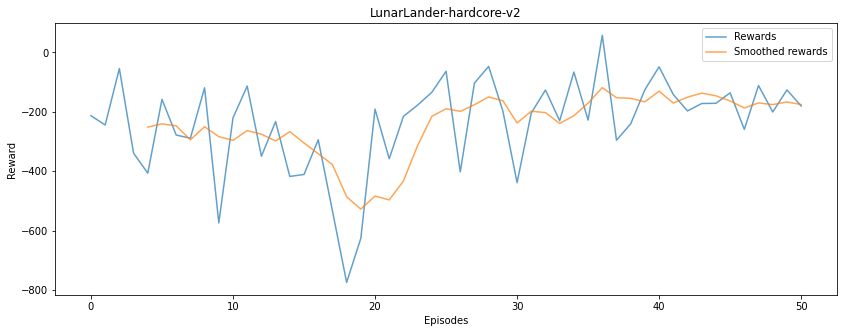

In [7]:
with tf.device("/cpu:0"):
    env = gym.make('LunarLander-hardcore-v2')
    val_env = env.unwrapped

    input_layer = Input(env.observation_space.shape)
    l = Dense(128, "relu")(input_layer)
    actor = Dense(env.action_space.n, "softmax", name="actor")(l)
    critic = Dense(1, name="critic")(l)
    model = Model(input_layer, [actor, critic])
    model.summary(50)
    
    opt = keras.optimizers.Adam(lr=0.01)
    critic_loss = keras.losses.Huber()

    acd = ActorCriticDiscrete(env, model, critic_loss, opt, 
                              val_env=val_env)

    acd_hist = acd.train(epochs=51, discount=0.99, 
                          max_train_steps=500, validate_every=50, 
                          val_episodes=15, max_val_steps=500, 
                          video=True, max_video_steps=500, 
                          avg_reward_goal=None)
    acd.plot_reward_history(acd_hist)

# Evaluation
***
Use the provided code to evaluate your agent. We will use `runs=1000` for final comparison.

Evaluation on vanilla environment `LunarLander-v2`:

In [10]:
mean_r = evaluate_easy(acd.sample_action, runs=100)

100%|████████████████████████████████████████| 100/100 [00:07<00:00, 13.95it/s]

[LunarLander-v2] Agent achieved -283.82 mean reward over 100 runs


Evaluation on hardcore environment `LunarLander-hardcore-v2`:

In [11]:
mean_r = evaluate_hardcore(acd.sample_action, runs=100)

100%|████████████████████████████████████████| 100/100 [00:07<00:00, 13.90it/s]

[LunarLander-hardcore-v2] Agent achieved -263.50 mean reward over 100 runs


### Try to get the highest possible reward!